In [2]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
import glob
import pickle
import shutil
from pathlib import Path
import sys
sys.path.append('/storage3/eva/code/remapping/src')
import path_formatting as pf
import oe
import motive
import utils

In [111]:
date = "20250916"
animal = "eb03"

path = f"/storage3/eva/data/processed/{animal}"
exps = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
print(exps)

['3of_hpc', 'f_vta_hpc', 'lt_hpc', 'f_vta_thal', 'trash']


In [ ]:
exp = exps[0]

oe_sr = 30000
m_sr = 120

dat_path, ks_path, csv_path, res_path = utils.path_load(date, animal,p=True)
os.makedirs(res_path, exist_ok=True) # Create the folder if it doesn't exist

# specific output
pp_path = Path(res_path) / "preprocessing"
pp_path.mkdir(parents=True, exist_ok=True)

dat_path, ks_path, csv_path, res_path

Ola! For folders inside of res_path: Path(res_path)/"folder_name"
To make new folder (if not exist): your_path.mkdir(parents=True, exist_ok=True)


('/storage3/eva/data/raw/oe/eb03/eb03_20250916/continuous.dat',
 '/storage3/eva/data/processed/eb03/eb03_20250916/kilosort',
 '/storage3/eva/data/processed/eb03/eb03_20250916/motive/out_csv',
 '/storage3/eva/code/neuropixels/results/eb03/eb03_20250916')

most of functions here got converted in .py files for further reuse

## Motive

### Positional data

In [77]:
def motive_quality(df, trial, save=False):

    # === Parse Meta Info ===
    motive_meta = df.iloc[0, 0:20].tolist()
    motive_meta = {motive_meta[i]: motive_meta[i + 1] for i in range(0, len(motive_meta) - 1, 2)}
    trial_duration = float(df.iloc[-1, 1])
    motive_meta['Duration'] = trial_duration

    # === Frame times & dt ===
    try:
        i = 6
        frame_times = df.iloc[i:, 1]
        frame_times = pd.to_numeric(frame_times, errors='coerce').dropna()
        dt = frame_times.diff().dropna()
    except:
        i = 7
        frame_times = df.iloc[i:, 1]
        frame_times = pd.to_numeric(frame_times, errors='coerce').dropna()
        dt = frame_times.diff().dropna()

    dt_us = dt * 1e6
    dt_min, dt_max = np.min(dt), np.max(dt)
    dt_diff_us = (dt_max - dt_min) * 1e6

    # === Position arrays & frame loss ===
    arrays, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
    nan_mask = np.isnan(arrays['X']) | np.isnan(arrays['Y']) | np.isnan(arrays['Z'])
    valid_mask = ~nan_mask
    x, y, z = arrays_interpol['X'], arrays_interpol['Y'], arrays_interpol['Z']

    loss_info = ""
    for key in ['X', 'Y', 'Z']:
        loss_count = np.isnan(arrays[key]).sum()
        loss_pct = 100 * loss_count / len(arrays[key])
        loss_info += f"{key}: {loss_count} ({loss_pct:.3f}%) lost frames\n"

    text_summary = (
        f"Trial: {trial}\n"
        f"___________________\n"
        f"Duration: {trial_duration:.2f} s; {trial_duration/60:.2f} min\n"
        f"fs: {motive_meta['Capture Frame Rate']} Hz\n"
        f"Frames nb: {motive_meta['Total Frames in Take']}\n"
        f"Rotation type': {motive_meta['Rotation Type']}\n"
        f"Length units': {motive_meta['Length Units']}\n"
        f"Coordinate space': {motive_meta['Coordinate Space']}\n"
        f"Min frame duration: {dt_min:.9f} s\n"
        f"Max frame duration: {dt_max:.9f} s\n"
        f"Difference: {dt_diff_us:.9f} μs\n"
        + loss_info
    )

    # === Create 2x2 plot layout ===
    fig, axes = plt.subplots(2, 2, figsize=(8, 7))

    # 1. Text summary (row 0, col 0)
    axes[0, 0].axis('off')
    axes[0, 0].text(0, 1, text_summary, va='top', ha='left', fontsize=10, family='monospace')

    # 2. XZ Trajectory with interpolation (row 0, col 1)
    axes[0, 1].scatter(x[valid_mask], z[valid_mask], c='grey', s=1, alpha=0.5)
    axes[0, 1].scatter(x[nan_mask], z[nan_mask], c='red', s=30, marker='x', label='Interpol')
    axes[0, 1].invert_xaxis()
    axes[0, 1].set_xlabel("X [m]")
    axes[0, 1].set_ylabel("Z [m]")
    axes[0, 1].set_title("XZ Traj")
    axes[0, 1].set_aspect('equal', adjustable='datalim')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # 3. IFI histogram (row 1, col 0)
    axes[1, 0].hist(dt_us, bins=50)
    axes[1, 0].set_xlabel('dt [μs]')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title('Inter-frame Interval (IFI)')

    # 4. dt over time (row 1, col 1)
    axes[1, 1].plot(dt_us[:100])
    axes[1, 1].set_xlabel('Sample index')
    axes[1, 1].set_ylabel('dt [μs]')
    axes[1, 1].set_title('dt over time (first 100)')
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        filename = f'motive_quality_{trial}'
        plt.savefig(os.path.join(pp_path, filename), dpi=300, bbox_inches='tight')
    plt.show()


In [78]:
csv_dict = motive.get_csv_dict(csv_path)
motive_keys = list(csv_dict.keys())
motive_keys

['20250916_1',
 '20250916_2',
 '20250916_3',
 '20250916_4',
 '20250916_5',
 '20250916_6',
 '20250916_7',
 '20250916_8',
 '20250916_9']

In [80]:
motive.get_meta(csv_dict['20250916_4'])

{'Format Version': '1.21',
 'Take Name': 'Take 2025-09-16 01.13.58 PM',
 'Capture Frame Rate': '120.000046',
 'Export Frame Rate': '120.000046',
 'Capture Start Time': '2025-09-16 01.13.58.013 PM',
 'Total Frames in Take': '182713',
 'Total Exported Frames': '182713',
 'Rotation Type': 'Quaternion',
 'Length Units': 'Meters',
 'Coordinate Space': 'Global',
 'Duration': 1522.599419}

In [81]:
motive.get_meta(csv_dict['20250916_6'])

{'Format Version': '1.21',
 'Take Name': 'Take 2025-09-16 02.33.33 PM',
 'Capture Frame Rate': '120.000046',
 'Export Frame Rate': '120.000046',
 'Capture Start Time': '2025-09-16 02.33.33.006 PM',
 'Total Frames in Take': '180341',
 'Total Exported Frames': '180341',
 'Rotation Type': 'Quaternion',
 'Length Units': 'Meters',
 'Coordinate Space': 'Global',
 'Duration': 1502.83276}

In [82]:
motive.get_meta(csv_dict['20250916_8'])

{'Format Version': '1.21',
 'Take Name': 'Take 2025-09-16 04.14.00 PM',
 'Capture Frame Rate': '120.000046',
 'Export Frame Rate': '120.000046',
 'Capture Start Time': '2025-09-16 04.14.00.760 PM',
 'Total Frames in Take': '181444',
 'Total Exported Frames': '181444',
 'Rotation Type': 'Quaternion',
 'Length Units': 'Meters',
 'Coordinate Space': 'Global',
 'Duration': 1512.024423}

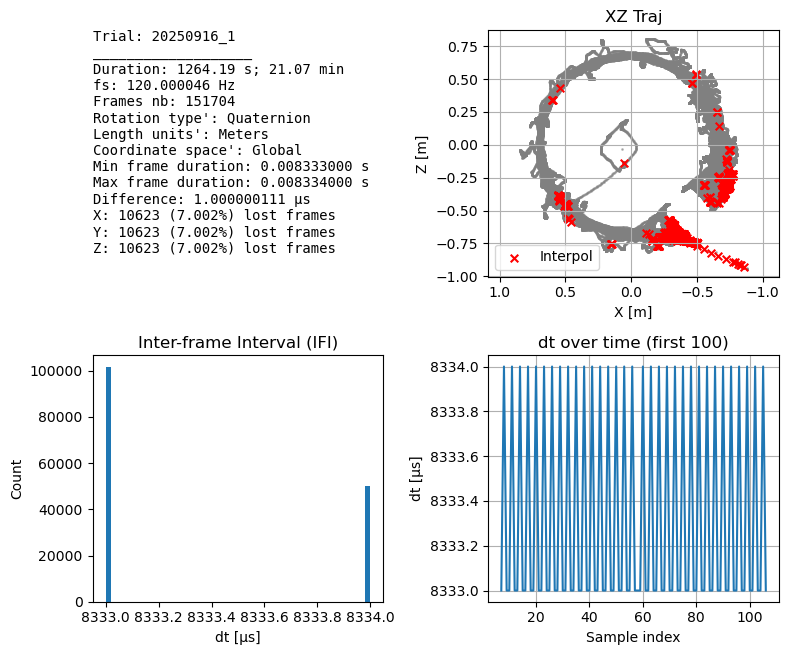

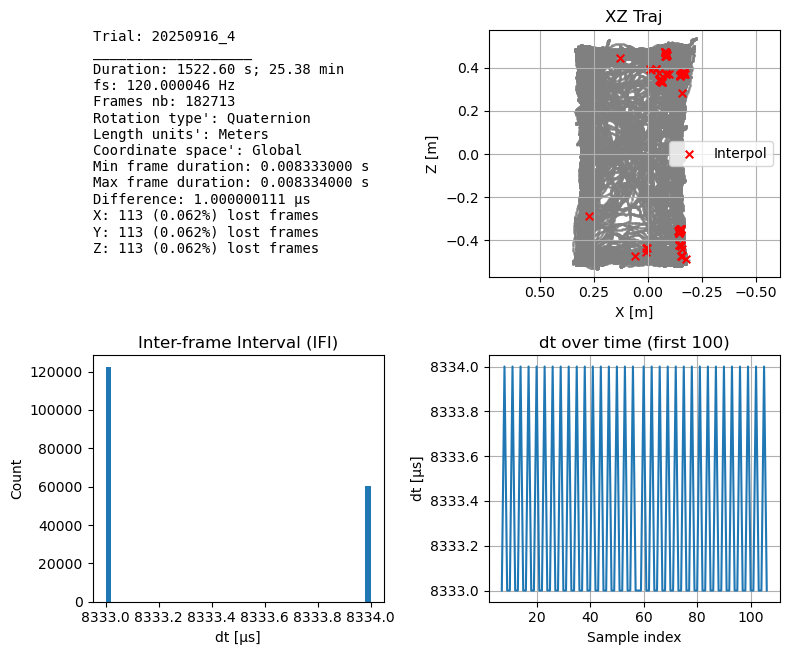

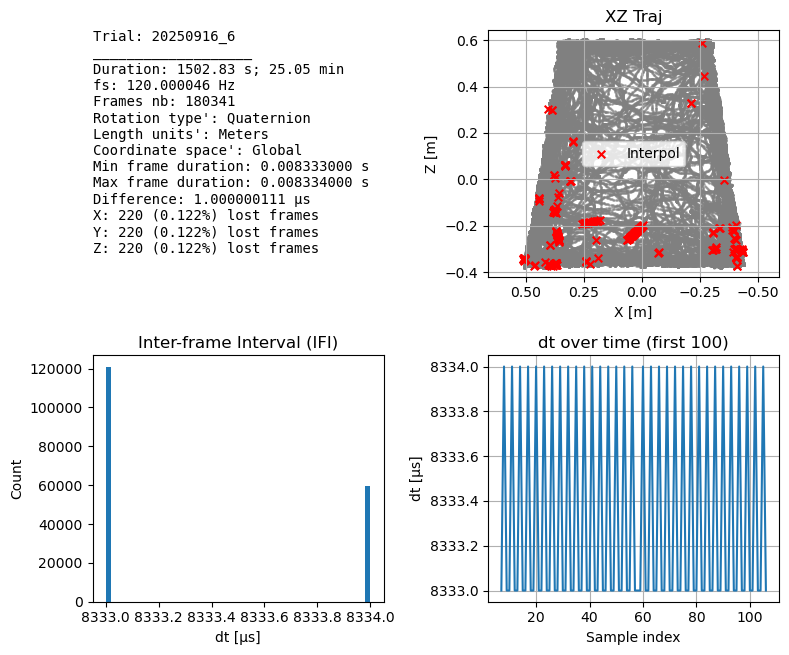

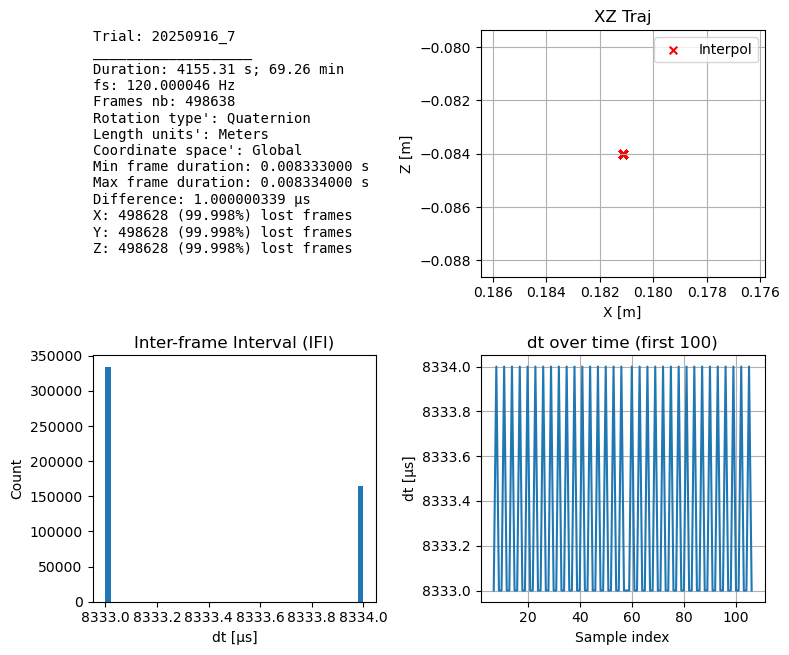

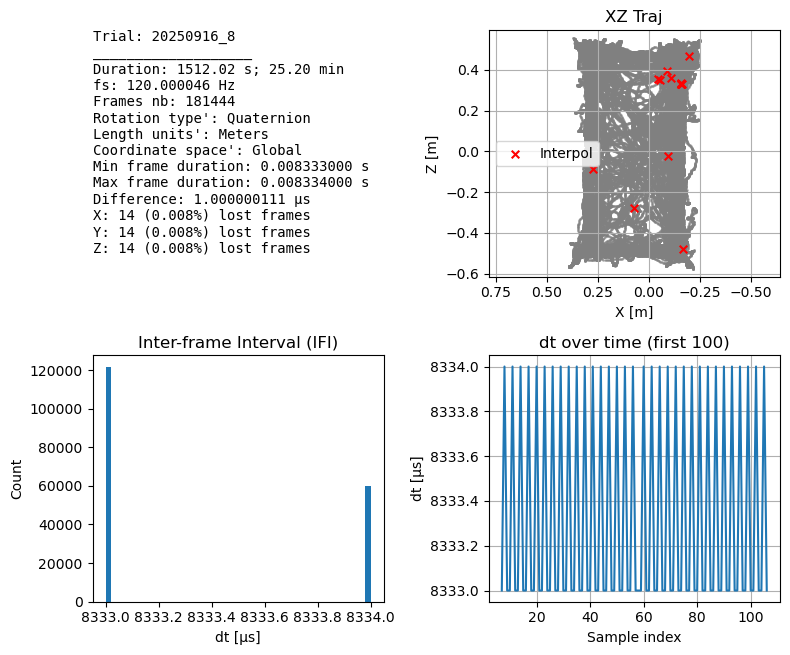

In [79]:
for trial in motive_keys:
    try:
        df = csv_dict[trial]
        motive_quality(df, trial, save=True)
    except:
        continue

In [83]:
of_keys = ['of1', 'of2', 'of3']
motive_keys = [f'{date}_4',f'{date}_6',f'{date}_8']
meta = dict(zip(of_keys, motive_keys))
with open(f"{pp_path}/meta_{date}.pkl", "wb") as f:
    pickle.dump(meta, f)
meta

{'of1': '20250916_4', 'of2': '20250916_6', 'of3': '20250916_8'}

In [ ]:
# of_keys = ['lt1']
# motive_keys = [f'{date}_4']
# meta = dict(zip(of_keys, motive_keys))
# with open(f"{pp_path}/meta_{date}.pkl", "wb") as f:
#     pickle.dump(meta, f)

In [84]:
def plot_trajectory(trial,x,z,c, c_name, c_units, save=False):
    plt.figure(figsize=(6, 4))
    sc = plt.scatter(x, z, c=c, cmap='plasma', s=1, alpha=0.5)
    plt.gca().invert_xaxis()
    plt.xlabel('X [m]')
    plt.ylabel('Z [m]')
    filename = f'xz_trjectory_{c_name}_{trial}'
    plt.colorbar(sc, label=f'{c_name} {c_units}')
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.title(filename)
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(pp_path, filename), dpi=300, bbox_inches='tight')
    plt.show()

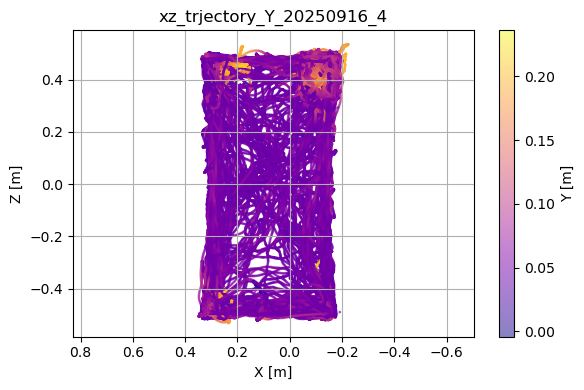

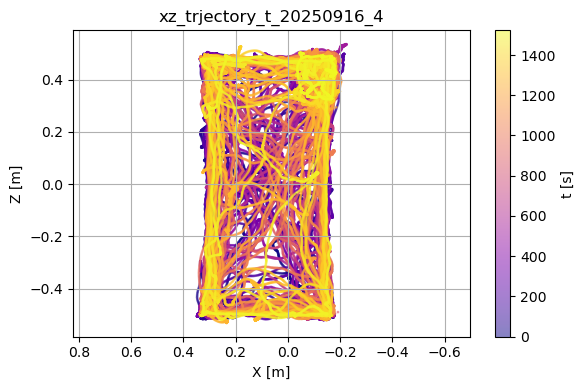

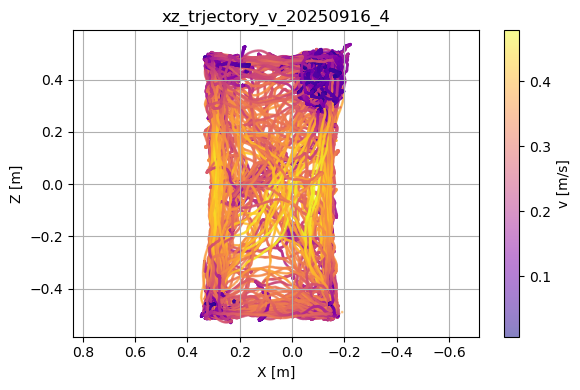

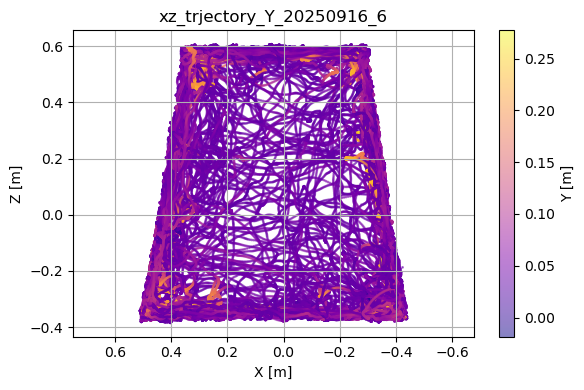

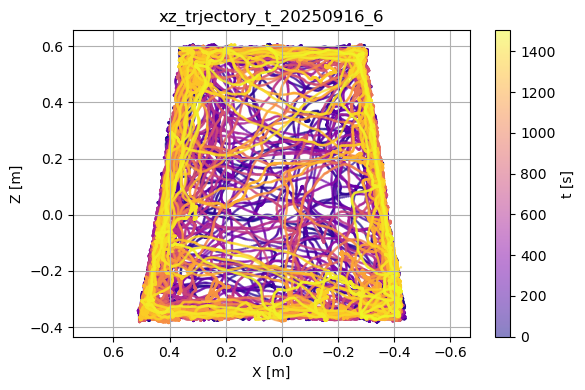

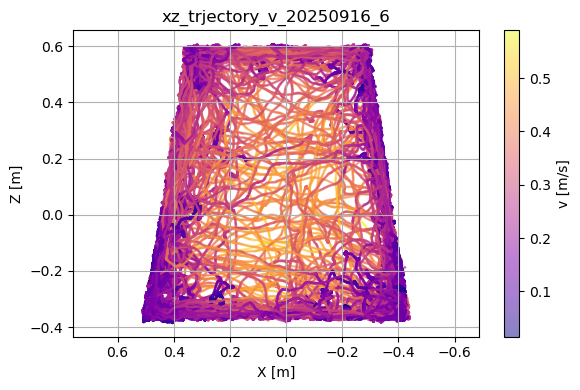

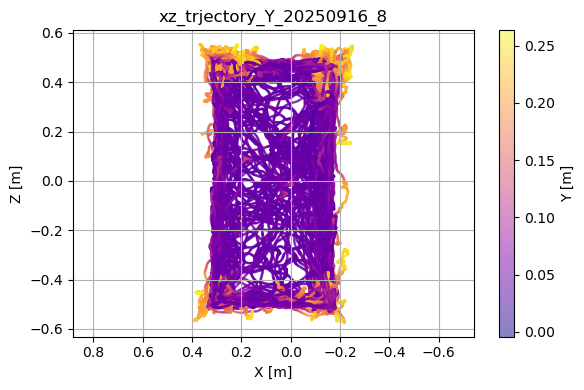

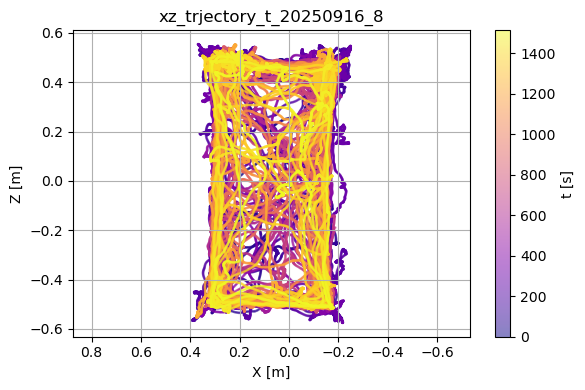

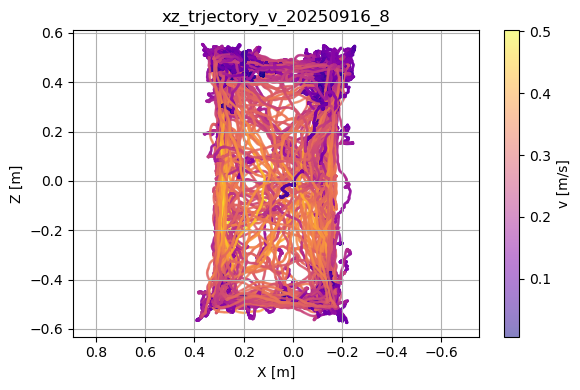

In [85]:
for trial in motive_keys:
    df = csv_dict[trial]
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
    x, y, z = arrays_interpol['X'], arrays_interpol['Y'], arrays_interpol['Z']
    t = motive.get_frame_times(df)
    _,_,v = motive.speed(x, z, t) # smoothed

    plot_trajectory(trial,x,z,y, 'Y','[m]', save=True)
    plot_trajectory(trial,x,z,t, 't','[s]', save=True)
    plot_trajectory(trial,x,z,v, 'v','[m/s]', save=True)

In [86]:
def v_plot(trial, v, t, save=False):
    fig, axes = plt.subplots(1, 2, figsize=(14, 3), gridspec_kw={'width_ratios': [1, 4]})

    # 1. Histogram of velocity
    axes[0].hist(v, bins=100)
    axes[0].set_xlabel('v [m/s]')
    axes[0].set_ylabel('Count')

    # 2. Velocity over time
    axes[1].plot(t, v)
    axes[1].set_xlabel('Time [s]')
    axes[1].set_ylabel('v [m/s]')

    filename = f"v_linear_xz_{trial}"
    fig.suptitle(filename)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(pp_path, filename), dpi=300, bbox_inches='tight')
    
    plt.show()

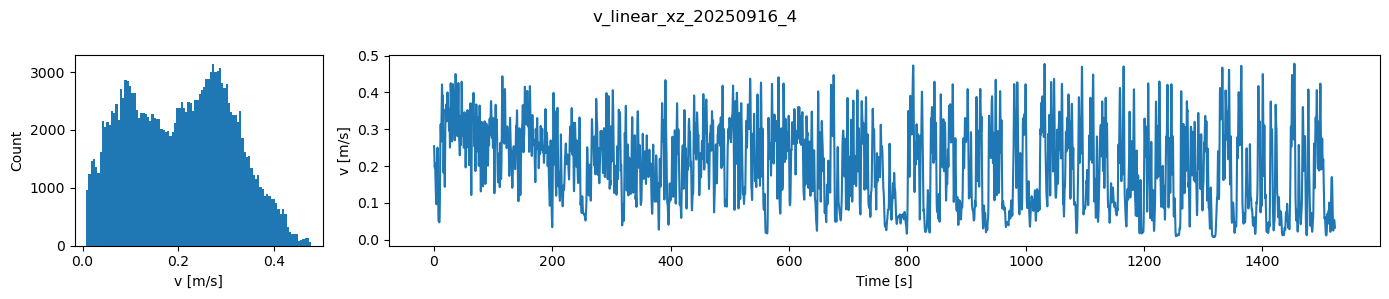

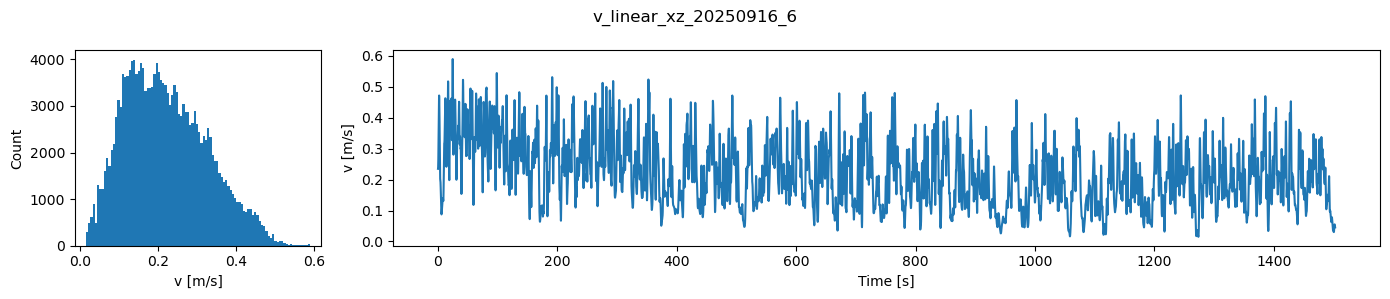

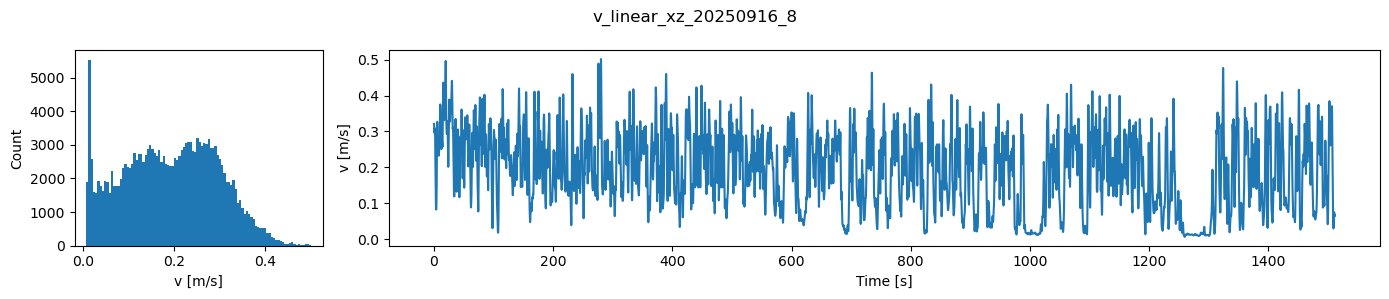

In [87]:
for trial in motive_keys:
    df = csv_dict[trial]
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array=['X', 'Y', 'Z'], interpolate=True)
    x, y, z = arrays_interpol['X'], arrays_interpol['Y'], arrays_interpol['Z']
    t = motive.get_frame_times(df)
    _,_,v = motive.speed(x, z, t)

    v_plot(trial, v, t, save=True)

### Rotations

In [88]:
from scipy.spatial.transform import Rotation as R

In [89]:
meta

{'of1': '20250916_4', 'of2': '20250916_6', 'of3': '20250916_8'}

In [90]:
def plot_jpdf_euler_height(of, y, roll, pitch, yaw, bins=50, save=False):
    """
    Plot joint PDFs of each Euler angle vs height, with Euler angles on x-axis.
    
    y      : array-like, height values
    roll   : array-like, roll angles (rad or deg)
    pitch  : array-like, pitch angles (rad or deg)
    yaw    : array-like, yaw angles (rad or deg)
    bins   : int or [int, int], number of bins for histogram2d
    """
    angles = [roll, pitch, yaw]
    names = ['Roll', 'Pitch', 'Yaw']

    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, ang, name in zip(axs, angles, names):
        # Now: angle is x-axis, height is y-axis
        H, xedges, yedges = np.histogram2d(ang, y, bins=bins, density=True)
        X, Y = np.meshgrid(xedges, yedges)
        pcm = ax.pcolormesh(X, Y, H.T, cmap='jet')
        ax.set_xlabel(f'{name} [deg]')
        ax.set_ylabel('Y [m]')
        fig.colorbar(pcm, ax=ax, label='Density')
    filename = f'jPDF_roll_pitch_yaw_{of}_{date}'
    fig.suptitle(filename)
    plt.tight_layout()
    if save:
        plt.savefig(pp_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

def yaw_speed(of,yaw, x,z, save=False):
    fig,axs = plt.subplots(1, 1, figsize=(4,3.5))
    d = -np.arctan2(np.diff(z), np.diff(x))
    direction = np.append(d, d[-1])
    v[v > 0.2] = 0.2 # for visualization
    
    this_plot = axs.scatter(yaw, direction, c=v, s=0.1, cmap='rainbow', alpha=0.5)
    axs.plot([-180, 180], [-np.pi, np.pi], 'k--', label='y=x')
    axs.set_xlabel('Yaw [deg]')
    axs.set_ylabel('Movement direction')
    axs.legend()
    fig.colorbar(this_plot, ax=axs, label='Speed [m/s]', fraction=0.046, pad=0.04)
    filename = f'yaw_direction_speed_{of}_{date}'
    fig.suptitle(filename)
    fig.tight_layout()
    if save:
        plt.savefig(pp_path / f"{filename}.png", dpi=300, bbox_inches='tight')    
    plt.show()

def hists(of,roll, pitch, yaw, save=False):
    eu_angles = ['roll', 'pitch', 'yaw']
    fig, axs = plt.subplots(1, 3, figsize=(9,3))
    axs = axs.flatten()
    for i, eu in enumerate([roll, pitch, yaw]):
        ax = axs[i]
        ax.hist(eu, bins=100)
        ax.set_xlabel(f'{eu_angles[i]} [deg]')
        ax.set_ylabel('Count')
    filename = f'hist_roll_pitch_yaw_{of}_{date}'
    fig.suptitle(filename)
    plt.tight_layout()
    if save:
        plt.savefig(pp_path / f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [91]:
ofs = list(meta.keys())
ofs

['of1', 'of2', 'of3']

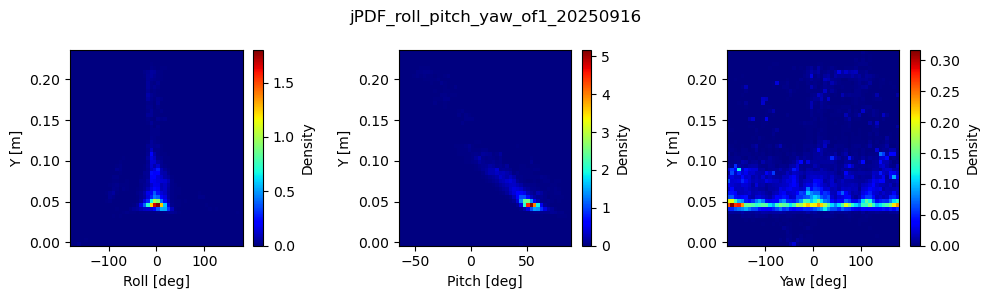

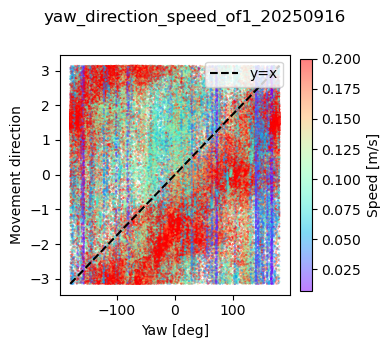

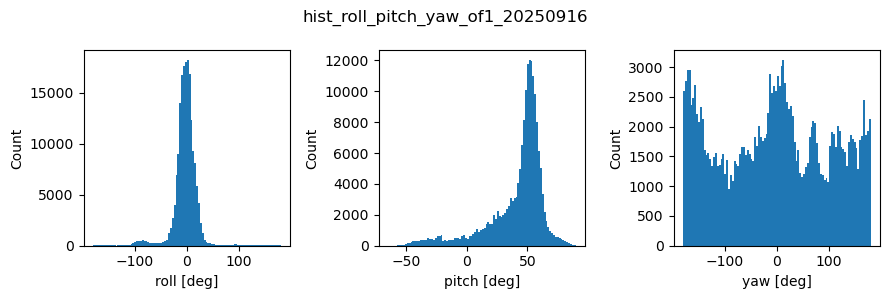

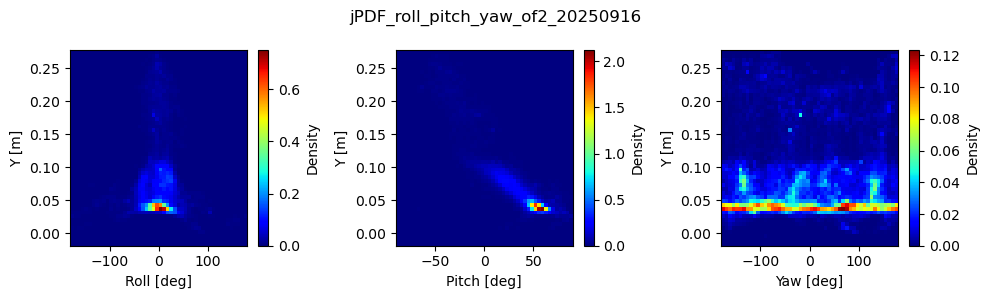

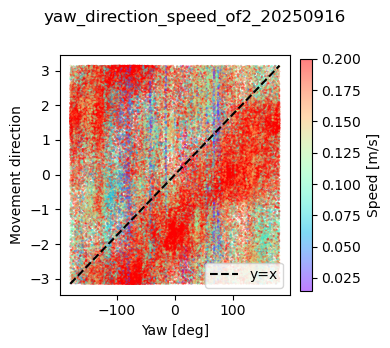

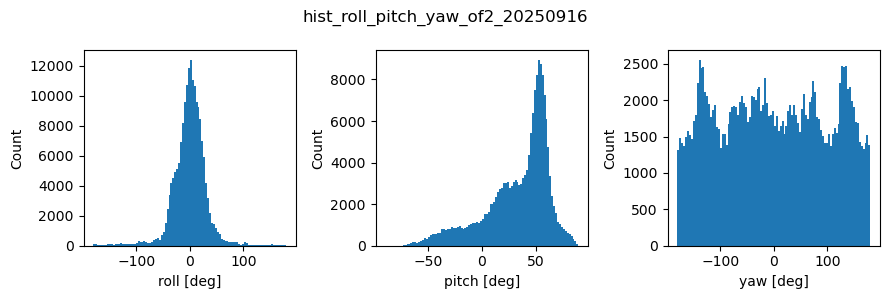

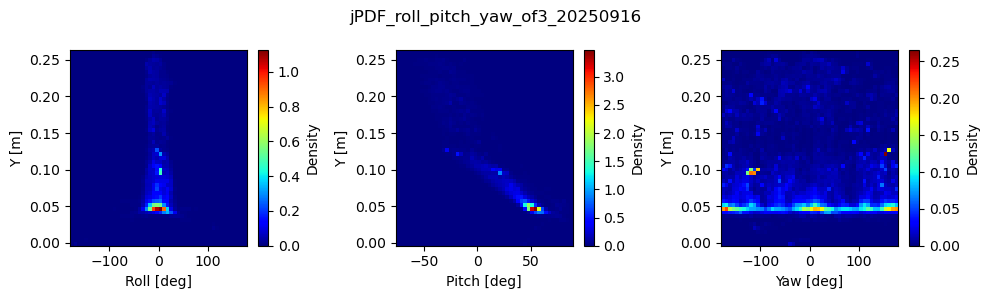

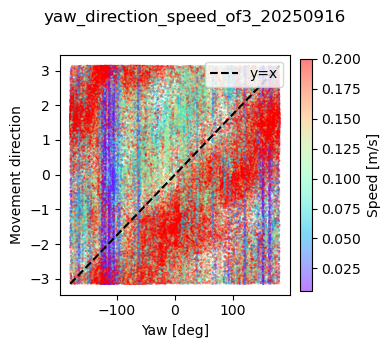

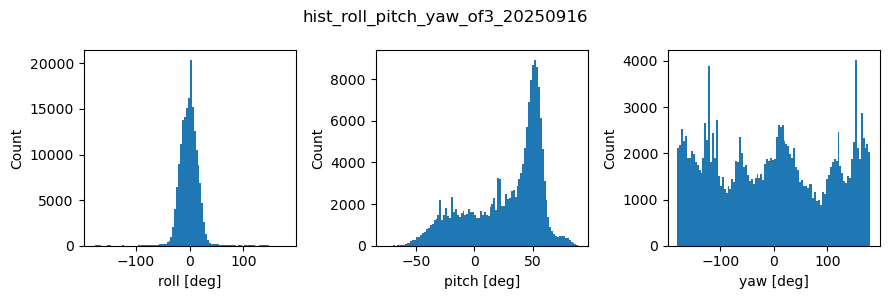

In [92]:
euler_dict = {}
qt = ['X','Y','Z','W']
save=True
for of in ofs:
    euler_dict[of] = {}

    df = csv_dict[meta[of]]

    t = motive.get_frame_times(df)
    _, arrays_interpol = motive.get_arrays(df, metric='Position', dim_array = ['X','Y','Z'], interpolate=True)
    x = arrays_interpol['X']
    y = arrays_interpol['Y']
    z = arrays_interpol['Z']
    _,_,v = motive.speed(arrays_interpol['X'], arrays_interpol['Z'], t)

    qt_arrays, qt_arrays_interpol = motive.get_arrays(df, metric='Rotation', dim_array = qt, interpolate=True)
    quaternions = np.array([
        qt_arrays_interpol['X'], 
        qt_arrays_interpol['Y'], 
        qt_arrays_interpol['Z'],
        qt_arrays_interpol['W']
        ]).T
    
    # u can do this
    eulers = R.from_quat(quaternions).as_euler('zxy', degrees=True) # intrinsic - rotate global coordinates to rb
    roll, pitch, yaw = eulers[:, 0], eulers[:, 1], eulers[:, 2]
    # # or this - same result
    # eulers = R.from_quat(quaternions).as_euler('YXZ', degrees=True) #extrinsis: back rotate rb to global coordinates
    # yaw, pitch, roll = eulers[:, 0], eulers[:, 1], eulers[:, 2]
    euler_dict[of]['roll'] = roll
    euler_dict[of]['pitch'] = pitch
    euler_dict[of]['yaw'] = yaw

    plot_jpdf_euler_height(of,y,roll, pitch, yaw, save=save)
    yaw_speed(of,yaw, x,z, save=save)
    hists(of,roll, pitch, yaw, save=save)

In [93]:
euler_dict

{'of1': {'roll': array([-14.5202153 , -14.3305817 , -13.65435769, ...,   8.52387904,
           8.50718023,   7.77352473], shape=(182713,)),
  'pitch': array([51.10176217, 53.81987586, 52.98540922, ..., 17.72788187,
         17.69107103, 18.82532686], shape=(182713,)),
  'yaw': array([ -99.40931998,  -99.53531459,  -98.05991389, ..., -114.93399276,
         -114.92151324, -114.86239653], shape=(182713,))},
 'of2': {'roll': array([-18.35376652, -17.84760226, -18.79196217, ..., -60.60580076,
         -62.8344443 , -71.33731566], shape=(180341,)),
  'pitch': array([53.13494484, 54.61510534, 55.666302  , ..., 43.90713735,
         42.85309682, 44.75380417], shape=(180341,)),
  'yaw': array([-140.42644346, -140.19608251, -141.25680342, ...,  -77.16309838,
          -78.84877442,  -85.35403741], shape=(180341,))},
 'of3': {'roll': array([-17.58342278, -10.92873176,  -5.83560819, ...,   5.17064369,
           5.4875672 ,   6.46092066], shape=(181444,)),
  'pitch': array([48.68231352, 50.21185

In [94]:
with open(f"{pp_path}/euler_dict_{date}.pkl", "wb") as f:
    pickle.dump(euler_dict, f)

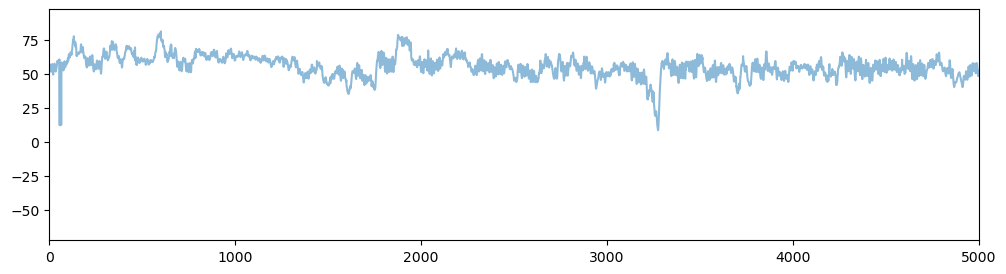

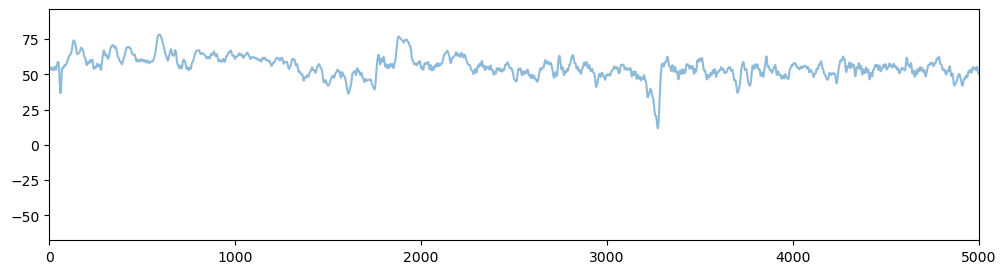

In [95]:
from scipy.ndimage import gaussian_filter1d
sigma=3
a=0
b=5000

plt.figure(figsize=(12,3))
plt.plot(euler_dict['of1']['pitch'], alpha=0.5)
plt.xlim([a,b])
plt.show()

plt.figure(figsize=(12,3))
plt.plot(gaussian_filter1d(euler_dict['of1']['pitch'], sigma=sigma), alpha=0.5)
plt.xlim([a,b])
plt.show()

In [96]:
smooth_pitch_dict = {}
sigma=3
for of in ofs:
    smooth_pitch_dict['sigma'] = sigma
    smooth_pitch_dict[of] = gaussian_filter1d(euler_dict[of]['pitch'], sigma=sigma)
smooth_pitch_dict

{'sigma': 3,
 'of1': array([53.78068103, 53.97231735, 54.29504208, ..., 17.97868127,
        18.0128995 , 18.03408445], shape=(182713,)),
 'of2': array([54.92678532, 54.88365376, 54.71507306, ..., 43.85252808,
        43.88483635, 43.90059902], shape=(180341,)),
 'of3': array([50.28127587, 50.39564831, 50.61432072, ..., 50.58798389,
        50.54881538, 50.5187017 ], shape=(181444,))}

In [97]:
with open(f"{pp_path}/smooth_pitch_dict_{date}.pkl", "wb") as f:
    pickle.dump(smooth_pitch_dict, f)

## OE

In [98]:
'''
load and save ttl 
only once!!!!!!!!!!!!!!!!!!!!!!!!!!!!
takes time
'''

data, idx = oe.load_binary(
    dat_path,
    channels=[384], # which channel/s to load
    n_channels=385,
    method=4,
    intype='int16', #16-bit integers
    outtype='float32',
    resample=1,
    return_orig_index=True
)

ttl = data[0,:]
data.shape, ttl.shape

np.save(Path(pp_path)/ f'ttl_from_mdat_{date}.npy', ttl)

In [99]:
# later load it like that
ttl = np.load(Path(pp_path)/ f'ttl_from_mdat_{date}.npy')

check the number of ttl pulses:
- 2 possibilities (noted in google sheets)
    - each period starts and ends with 1 ttl 
    - or we have ttls strobbing for a whole session with even intervals
- each ttl has 1 rising and 1 falling edge
-so if u have only start/end ttls --> 7 periods * 2 = 14 ttls (--> 14 rising edges and 14 falling)


In [100]:
rising_edges = np.where((ttl[:-1] == 0) & (ttl[1:] == 1))[0] + 1
print("Rising edge indices:", rising_edges)
print(len(rising_edges)) # sould be 14

falling_edges = np.where((ttl[:-1] == 1) & (ttl[1:] == 0))[0] + 1
print(len(falling_edges)) # sould be 14

Rising edge indices: [   127975  56425379  56819937 102498062 102783168 187866147 188244712
 233329826 233560285 358096390 403457330 403783435]
12
12


means we have start/end ttl configuration:
- easy
- doesnt allow to assess clock drift

In [101]:
# check if ttls have equal durations
durations = falling_edges - rising_edges # in samples
durations

array([250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250])

samples? 
sampling rate for ephys is `30 000 Hz` (30k samples per sec), motive - `120 Hz`

- `1 Hz = 1 sample/ 1 sec`
- --> to get time: `1 sec = 1 sample/ 1Hz`
- **so to get time u have to divide samples on ur sampling rate**

In [102]:
# quick check if ttl corresponds to frame duration of motive (they should)
# dividing on sampling rate
print(f'motive frame duration {1/m_sr}, ttl duration {durations[0]/oe_sr}')

motive frame duration 0.008333333333333333, ttl duration 0.008333333333333333


In [103]:
# now lets see the duration of our sessions
rising_edges_diff  =np.diff(rising_edges)
(rising_edges_diff/oe_sr)/60 # ipi in min

array([31.27633556,  0.21919889, 25.37673611,  0.15839222, 47.26832167,
        0.21031389, 25.04728556,  0.12803278, 69.186725  , 25.20052222,
        0.18116944])

In [31]:
# from my table sl2 and sl3 and sl4 didnt have end_ttl

In [66]:
print("Rising edge indices:", rising_edges)
print("Falling edge indices:", falling_edges)

Rising edge indices: [   105378  31473251  85574372  85837617 160741919 161014162 206401323
 206757155 277511909 277813396 322905065 323202852 391216118]
Falling edge indices: [   105628  31473501  85574622  85837867 160742169 161014412 206401573
 206757405 277512159 277813646 322905315 323203102 391216368]


In [69]:
len(ttl[:rising_edges[0]])/oe_sr/60

0.05854333333333333

In [104]:
# # fixing

ttl = ttl.copy()
pulse_length = durations[0]  # e.g. 250 samples

start_edge_1 = rising_edges[9] - 251
ttl[start_edge_1:start_edge_1+250] = 1

start_edge_2 = ttl.shape[0]-251
ttl[start_edge_2:start_edge_2+250] = 1

# start_edge_2 = rising_edges[8] - 251
# ttl[start_edge_2:start_edge_2+250] = 1

# start_edge_3 = ttl.shape[0]-251
# ttl[start_edge_3:start_edge_3+250] = 1

In [105]:
# just checking..
 
rising_edges = np.where((ttl[:-1] == 0) & (ttl[1:] == 1))[0] + 1
print("Rising edge indices:", rising_edges)
print(len(rising_edges)) # sould be 14

falling_edges = np.where((ttl[:-1] == 1) & (ttl[1:] == 0))[0] + 1
print(len(falling_edges)) # sould be 14

# check if ttls have equal durations
durations = falling_edges - rising_edges # in samples
print(durations)

# now lets see the duration of our sessions
rising_edges_diff  =np.diff(rising_edges)
ipi_min = (rising_edges_diff / oe_sr) / 60
print(np.round(ipi_min, 2))


Rising edge indices: [   127975  56425379  56819937 102498062 102783168 187866147 188244712
 233329826 233560285 358096139 358096390 403457330 403783435 599157144]
14
14
[250 250 250 250 250 250 250 250 250 250 250 250 250 250]
[ 31.28   0.22  25.38   0.16  47.27   0.21  25.05   0.13  69.19   0.
  25.2    0.18 108.54]


NB! every 2nd short duration is a bridge between periods since we merged dat files in one to ks it altogether

so u look for 1st, 3rd, 5, 7,...

**if some ttl is missing** u should introduce it artificially (job for Eva); it was the case with our firsth session where 1 ttl after 1st sleep was missing

- so i saw 13 rising edges
- in `rising_edges_diff` 1 short bridge was missing
- it helped me to locate the missing ttl
- below the commented code showng how it can be done

In [ ]:
# load unmerged .dat file where u suspect the missed ttl

# s1_path = f'/storage3/eva/data/raw/{animal}/2025-07-17_09-47-11/Record Node 101/experiment1/recording1/continuous/OneBox-111.ProbeA/continuous.dat'

# s1, idx = load_binary(
#     s1_path,
#     channels=[384], # which channel/s to load
#     n_channels=385,
#     method=4,
#     intype='int16',
#     outtype='float32',
#     resample=1,
#     return_orig_index=True
# )
# s1 = s1[0,:]
# s1.shape

In [ ]:
# np.where((s1[:-1] == 0) & (s1[1:] == 1))[0] + 1

In [ ]:
# find 1st sleep rec duration from motive in sec
# df - motive df of ur missed period (load it)

# motive_duration = motive.get_frame_times(df)[-1] # this function will be introduced in later notebooks
# delay_from_first_rise = motive_duration*oe_sr

In [ ]:
# # fixing

# ttl = ttl.copy()
# pulse_length = durations[0]  # 250 in samples
# first_rising_edge = rising_edges[0]


# # Start and end index for the new pulse

# start_new_pulse = first_rising_edge + delay_from_first_rise
# end_new_pulse = start_new_pulse + pulse_length

# # Inject artificial pulse
# ttl[start_new_pulse:end_new_pulse] = 1

In [ ]:
# # update rising/falling edges
# rising_edges = np.where((ttl[:-1] == 0) & (ttl[1:] == 1))[0] + 1
# falling_edges = np.where((ttl[:-1] == 1) & (ttl[1:] == 0))[0] + 1
# print(len(rising_edges))
# durations = falling_edges - rising_edges
# print(durations)

# rising_edges_diff  =np.diff(rising_edges)
# (rising_edges_diff/sr)/60 # ipi in min

In [ ]:
# should be properly now

In [106]:
# Define period names in order
period_names = ['sl1', 'of1', 'sl2', 'of2', 'sl3', 'of3', 'sl4']
# period_names = ['sl1', 'lt1', 'sl2']

# Generate dictionary of periods
periods = {name: [rising_edges[2*i], rising_edges[2*i+1]] for i, name in enumerate(period_names)}

# Optionally unpack them as variables
globals().update(periods)

periods

{'sl1': [np.int64(127975), np.int64(56425379)],
 'of1': [np.int64(56819937), np.int64(102498062)],
 'sl2': [np.int64(102783168), np.int64(187866147)],
 'of2': [np.int64(188244712), np.int64(233329826)],
 'sl3': [np.int64(233560285), np.int64(358096139)],
 'of3': [np.int64(358096390), np.int64(403457330)],
 'sl4': [np.int64(403783435), np.int64(599157144)]}

In [107]:
# save them to save ur time later!!!

with open(Path(pp_path) / f"behav_periods_{animal}_{date}.pkl", "wb") as f:
    pickle.dump(periods, f)

In [ ]:
# to load later

# res_path_path = Path(res_path)

# with open(res_path_path / f"behav_periods_{animal}_{date}.pkl", "rb") as f:
#     periods = pickle.load(f)

In [108]:
# u can look at durations
for key in periods.keys():
    print(key, (periods[key][1]-periods[key][0])/oe_sr/60, '[min]')

sl1 31.276335555555555 [min]
of1 25.37673611111111 [min]
sl2 47.268321666666665 [min]
of2 25.047285555555558 [min]
sl3 69.18658555555557 [min]
of3 25.200522222222222 [min]
sl4 108.54094944444445 [min]
